In [4]:
import torch
import torch.nn as nn
import torchsummary

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Inceptin-v1

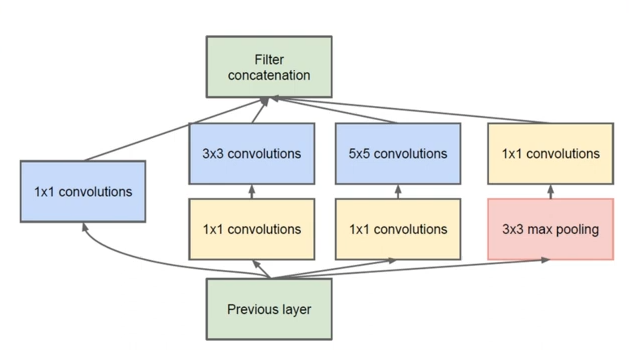

In [73]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, pool_n):
        super(InceptionModule, self).__init__()

        # 1x1 conv layer
        self.conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, 1, 1),  # kernel=1, stride=1
            nn.BatchNorm2d(out_1x1),
            nn.ReLU()
        )

        # 1x1 conv layer -> 3x3 conv layer
        self.conv1_3 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, 1, 1),  # kernel=1, stride=1
            nn.BatchNorm2d(red_3x3),
            nn.ReLU(),
            nn.Conv2d(red_3x3, out_3x3, 3, 1, 1),  # kernel=3, stride=1, padding=1
            nn.BatchNorm2d(out_3x3),
            nn.ReLU()
        )

        # 1x1 conv layer -> 5x5 conv layer
        self.conv1_5 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, 1, 1),  # kernel=1, stride=1
            nn.BatchNorm2d(red_5x5),
            nn.ReLU(),
            nn.Conv2d(red_5x5, out_5x5, 5, 1, 2),  # kernel=5, stride=1, padding=2
            nn.BatchNorm2d(out_5x5),
            nn.ReLU()
        )

        # 3x3 max pooling layer -> 1x1 conv layer
        self.max3_1 = nn.Sequential(
            nn.MaxPool2d(3, 1, 1),  # kernel=3, stride=1, padding=1
            nn.Conv2d(in_channels, pool_n, 1, 1),  # kernel=1, stride=1
            nn.BatchNorm2d(pool_n),
            nn.ReLU()
        )

    def forward(self, x):
        out_1 = self.conv1_1(x)
        out_2 = self.conv1_3(x)
        out_3 = self.conv1_5(x)
        out_4 = self.max3_1(x)

        output = torch.cat([out_1, out_2, out_3, out_4], 1)
        return output

In [75]:
test = InceptionModule(192,64,96,128,16,32,32)
torchsummary.summary(test, input_size=(192,28,28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]          12,352
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 96, 28, 28]          18,528
       BatchNorm2d-5           [-1, 96, 28, 28]             192
              ReLU-6           [-1, 96, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]         110,720
       BatchNorm2d-8          [-1, 128, 28, 28]             256
              ReLU-9          [-1, 128, 28, 28]               0
           Conv2d-10           [-1, 16, 28, 28]           3,088
      BatchNorm2d-11           [-1, 16, 28, 28]              32
             ReLU-12           [-1, 16, 28, 28]               0
           Conv2d-13           [-1, 32, 28, 28]          12,832
      BatchNorm2d-14           [-1, 32,

### Auxiliary classifier

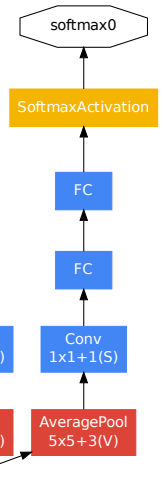

In [99]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.avgpool = nn.AvgPool2d(5, 3)  # kernel=5, stride=3
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 128, 1, 1),
            nn.BatchNorm2d(128), 
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128*4*4, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.7),
            nn.Linear(1024,num_classes)
        )

    def forward(self,x):
        x = self.avgpool(x)
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

### GoogLeNet

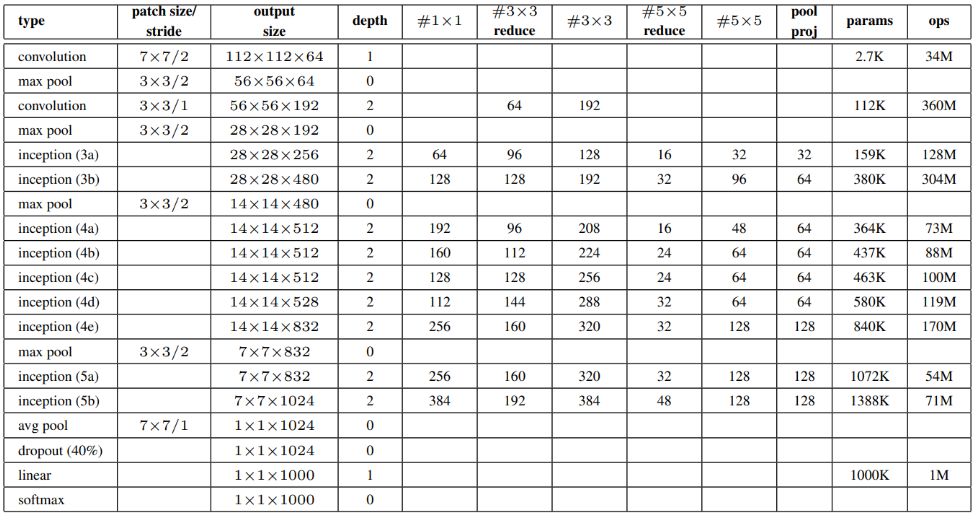

In [102]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(GoogLeNet, self).__init__()
        self.num_classes = num_classes
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(3, 2, 1),
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(3, 2, 1)
        )

        self.layer2 = nn.Sequential(
            InceptionModule(192, 64, 96, 128, 16, 32, 32),
            InceptionModule(256, 128, 128, 192, 32, 96, 64),
            nn.MaxPool2d(3, 2, 1)
        )

        self.Inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.aux1 = InceptionAux(512, num_classes)
        
        self.layer3 = nn.Sequential(
            InceptionModule(512, 160, 112, 224, 24, 64, 64),
            InceptionModule(512, 128, 128, 256, 24, 64, 64)
        )

        self.Inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.aux2 = InceptionAux(528, num_classes)

        self.layer4 = nn.Sequential(
            InceptionModule(528, 256, 160, 320, 32, 128, 128),
            nn.MaxPool2d(3, 2, 1),
            InceptionModule(832, 256, 160, 320, 32, 128, 128),
            InceptionModule(832, 384, 192, 384, 48, 128, 128),
            nn.AvgPool2d(7, 1)
        )

        self.dropout = nn.Dropout2d(0.4)
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.Inception4a(out)

        if self.training:
            out1 = self.aux1(out)

        out = self.layer3(out)
        out = self.Inception4d(out)

        if self.training:
            out2 = self.aux2(out)

        out = self.layer4(out)
        
        out = out.view(-1, 1024)
        
        out = self.dropout(out)

        out = self.fc(out)

        if self.training:
            return out, out1, out2

        else:
            return out

In [104]:
test = GoogLeNet()
torchsummary.summary(test, input_size=(3, 224, 224), batch_size=64, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 112, 112]           9,472
         MaxPool2d-2           [64, 64, 56, 56]               0
            Conv2d-3          [64, 192, 56, 56]         110,784
         MaxPool2d-4          [64, 192, 28, 28]               0
            Conv2d-5           [64, 64, 28, 28]          12,352
       BatchNorm2d-6           [64, 64, 28, 28]             128
              ReLU-7           [64, 64, 28, 28]               0
            Conv2d-8           [64, 96, 28, 28]          18,528
       BatchNorm2d-9           [64, 96, 28, 28]             192
             ReLU-10           [64, 96, 28, 28]               0
           Conv2d-11          [64, 128, 28, 28]         110,720
      BatchNorm2d-12          [64, 128, 28, 28]             256
             ReLU-13          [64, 128, 28, 28]               0
           Conv2d-14           [64, 16,

C:\Users\psg88\anaconda3\envs\deeplearn\lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


### Dataset

In [157]:
import torchvision
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [117]:
train = datasets.STL10(root='./data/', split='train', download=True, transform=transforms.ToTensor())
test = datasets.STL10(root='./data/', split='test', download=True, transform=transforms.ToTensor())

100.0%


Extracting ./data/stl10_binary.tar.gz to ./data/
Files already downloaded and verified


In [183]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train]
train_stdRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train]

meanR = np.mean([m[0] for m in train_meanRGB])
meanG = np.mean([m[1] for m in train_meanRGB])
meanB = np.mean([m[2] for m in train_meanRGB])
stdR = np.std([s[0] for s in train_stdRGB])
stdG = np.std([s[1] for s in train_stdRGB])
stdB = np.std([s[2] for s in train_stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

2.8341674e-05 2.5780488e-05 1.8665314e-05
1.0000117 1.0000085 1.0000042


In [184]:
data_transformer = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(meanR, meanG, meanB), std=(stdR, stdG, stdB))
                                      ])

train.transform = data_transformer
test.transform = data_transformer

trainloader = DataLoader(train, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(test, batch_size=64, shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8341343e-05..0.9999772].


image indices: [2732 2607 1653 3264]
torch.Size([3, 228, 906])


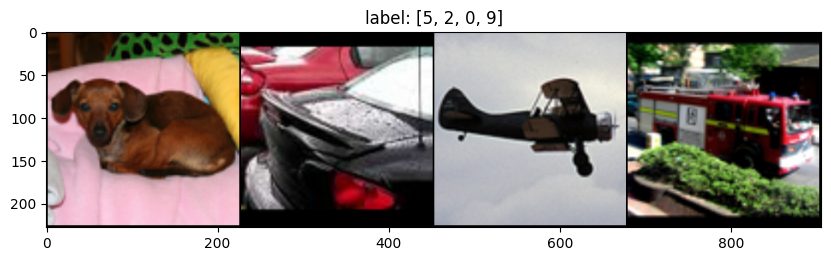

In [185]:
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('label: '+ str(y))

np.random.seed(0)
torch.manual_seed(0)

rnd_inds = np.random.randint(0, len(train), 4)
print('image indices:', rnd_inds)

x_grid=[train[i][0] for i in rnd_inds]
y_grid=[train[i][1] for i in rnd_inds]

x_grid = make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid, y_grid)

In [186]:
learning_rate = 0.0002

steps_per_epoch = len(trainloader)
scheduler_gamma = 0.04

epochs_per_lr_decay = 8
scheduler_step_size = steps_per_epoch * epochs_per_lr_decay

model = GoogLeNet().to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

In [187]:
num_epoch = 10
loss_arr = []

for i in range(num_epoch):
    for j, [img, label] in enumerate(trainloader):
        x = img.to(device)
        y = label.to(device)

        optimizer.zero_grad()
        pred1, pred2, pred3 = model.forward(x)

        if model.training:
            loss1 = loss_func(pred1, y)
            loss2 = loss_func(pred2, y)
            loss3 = loss_func(pred3, y)
            loss = loss1+loss2+0.3 + loss3*0.3
        
        loss.backward()
        optimizer.step()

    scheduler.step()

    if i % 10 == 0:
        print(f"Epoch [{i}/{num_epoch}], Loss: {loss.item()}")
        loss_arr.append(loss.cpu().detach().numpy())

Epoch [0/10], Loss: 4.920454978942871


In [188]:
correct = 0
total = 0
loss_total = 0

model.eval()

with torch.no_grad():
    for img, labels in testloader:
        x = img.to(device)
        y = labels.to(device)

        output = model(x)

        loss = loss_func(output, y)
        loss_total += loss.item()

        _, pred = torch.max(output, 1)
        total += y_.size(0)
        correct += (pred == y_).sum().item()

accuracy = 100 * correct / total
avg_loss = loss_total / len(testloader)

print(f"Test Accuracy: {accuracy:.2f}% | Average Loss: {avg_loss:.4f}")

Test Accuracy: 9.59% | Average Loss: 1.4618
